## Project Title: Predicting Customer Churn: Uncovering Key Indicators and Retention Strategies


## Introduction

Customer churn, also known as customer attrition or customer turnover, refers to the percentage of customers who cease using a company's product or service within a given timeframe. Understanding and predicting customer churn is crucial for organizations as it directly impacts their profitability and growth. By identifying the factors that contribute to churn, businesses can develop effective retention strategies to mitigate this problem.

In this project, we will analyze a dataset containing various customer attributes such as gender, age, partner status, internet service provider, contract term, and payment method, among others. We aim to explore the relationship between these attributes and the likelihood of customer churn. By conducting a thorough analysis, we can uncover key indicators of churn and identify patterns that indicate a higher propensity for customers to leave the organization.

## Objectives

1.Build a classification model to predict customer churn and assess the likelihood of a customer leaving the organization.

2.Identify key indicators or factors that contribute to customer churn.

3.Formulate effective retention strategies based on the identified indicators to mitigate customer attrition.

## Hypothesis

**Null Hypothesis**: There is no significant relationship between the various customer attributes and the likelihood of customer churn.

**Alternatative Hypothesis**: There is a significant relationship between the various customer attributes and the likelihood of customer churn.

## Questions

1.What are the key indicators of customer churn in this dataset?

2.Is there any correlation between the type of internet service provider and customer churn?

3.What is the relationship between contract terms and customer churn?

4.Which payment method is associated with higher customer churn?

5.How can the organization leverage payment methods, contract terms, and billing preferences to reduce churn?

## Importing python libraries

In [1]:
%pip install pyodbc 
%pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyodbc
import pandas as pd
from dotenv import dotenv_values
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import pickle

warnings.filterwarnings('ignore')

## Data Loading
This dataset is a concatenation of three datasets extracted from different sources as follows:
1. SQL Database.(named _LP2_Telco_churn_first_3000_)
1. OneDrive.(_Telco-churn-second-2000.csv_)
1. Github repository.(_LP2_Telco-churn-last-2000.csv_)


In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [4]:

server = environment_variables.get("server")
database = environment_variables.get("database")
username = environment_variables.get("username")
password = environment_variables.get("password")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# connect to SQL Database
connection = pyodbc.connect(connection_string)

In [6]:
# query database to read the selected table
query = "Select * from dbo.LP2_Telco_churn_first_3000"
data = pd.read_sql(query, connection)

In [7]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [8]:
data.to_csv('LP2_Telco_churn_first_3000.csv')

In [9]:
data2 = pd.read_csv('LP2_Telco-churn-last-2000.csv')
data2

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [10]:
# concatenate 
df = pd.concat([data, data2])
df.to_csv('LP2_Telco-churn-complete1.csv')

In [11]:
df=pd.read_csv('LP2_Telco-churn-complete1.csv')
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True
3,3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.64999389648438,True


## Exploratory Data Analysis(EDA)

In [12]:
df.shape

(5043, 22)

In [13]:
df.sample(15)

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3971,971,9800-OUIGR,Male,0,Yes,Yes,66,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.000000,1374.2,No
3991,991,8063-RJYNF,Male,0,No,No,16,Yes,No,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.250000,1483.25,Yes
1742,1742,5318-IXUZF,Female,0,False,False,2,True,False,Fiber optic,...,False,False,True,False,Month-to-month,True,Bank transfer (automatic),87.150002,183.75,True
2685,2685,5781-BKHOP,Female,0,True,False,72,True,True,Fiber optic,...,True,False,True,False,Two year,False,Bank transfer (automatic),100.650002,7334.0498046875,False
1615,1615,2812-REYAT,Female,0,True,False,49,True,False,No,...,NaN,NaN,NaN,NaN,One year,True,Bank transfer (automatic),20.049999,923.0999755859375,False
3083,83,7136-IHZJA,Female,0,Yes,Yes,40,Yes,No,DSL,...,No,Yes,No,Yes,Month-to-month,Yes,Mailed check,71.350000,2847.2,No
157,157,2749-CTKAJ,Male,0,True,True,22,True,False,No,...,NaN,NaN,NaN,NaN,One year,False,Mailed check,20.150000,419.8999938964844,False
3475,475,1114-CENIM,Male,0,No,Yes,54,Yes,Yes,DSL,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),55.000000,3092.65,Yes
891,891,3804-RVTGV,Male,0,True,True,50,True,True,Fiber optic,...,True,False,True,True,Month-to-month,True,Bank transfer (automatic),103.849998,5017.89990234375,True
1269,1269,8480-PPONV,Male,0,True,True,62,True,True,Fiber optic,...,True,True,True,True,Two year,False,Bank transfer (automatic),115.550003,7159.0498046875,False


In [14]:
df.dtypes

Unnamed: 0            int64
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5043 non-null   int64  
 1   customerID        5043 non-null   object 
 2   gender            5043 non-null   object 
 3   SeniorCitizen     5043 non-null   int64  
 4   Partner           5043 non-null   object 
 5   Dependents        5043 non-null   object 
 6   tenure            5043 non-null   int64  
 7   PhoneService      5043 non-null   object 
 8   MultipleLines     4774 non-null   object 
 9   InternetService   5043 non-null   object 
 10  OnlineSecurity    4392 non-null   object 
 11  OnlineBackup      4392 non-null   object 
 12  DeviceProtection  4392 non-null   object 
 13  TechSupport       4392 non-null   object 
 14  StreamingTV       4392 non-null   object 
 15  StreamingMovies   4392 non-null   object 
 16  Contract          5043 non-null   object 


In [16]:
# sum of null values
df.isnull().sum()

Unnamed: 0            0
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [17]:
df.drop(columns={'Unnamed: 0'}, inplace = True)

In [18]:
df['Churn'].value_counts()


False    2219
No       1487
True      780
Yes       556
Name: Churn, dtype: int64

In [19]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5043.000000,5043.000000,5043.000000
mean,0.162403,32.576641,65.090214
std,0.368857,24.529807,30.068133
min,0.000000,0.000000,18.400000
25%,0.000000,9.000000,35.775000
50%,0.000000,29.000000,70.550003
75%,0.000000,56.000000,90.050003
max,1.000000,72.000000,118.650002


In [20]:
# categorical and numerical columns
cat=[]
num=[]

for column in df.columns:
    if df[column].nunique()> 9:
        num.append(column)
    else:
        cat.append(column)

In [21]:
cat

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [22]:
num

['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [23]:
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [24]:
df['Churn'].unique()

array(['False', 'True', nan, 'No', 'Yes'], dtype=object)

In [25]:
df['Churn'] = df['Churn'].replace({'False': 'No', 'True': 'Yes'})


## Univariate Analysis

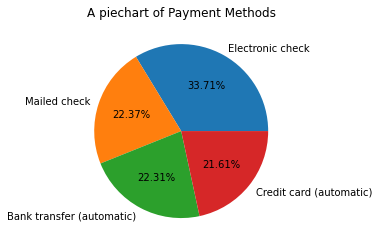

In [26]:
df['PaymentMethod'].value_counts().plot(kind='pie',autopct='%1.2f%%', title='A piechart of Payment Methods',label='');

**Electronic check** is the most used payment method by customers, followed by **mailed check**.

In [27]:
df['gender'].value_counts()

Male      2559
Female    2484
Name: gender, dtype: int64

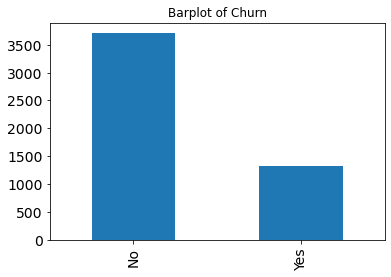

In [28]:
df['Churn'].value_counts().plot(kind='bar',title='Barplot of Churn',fontsize=14);

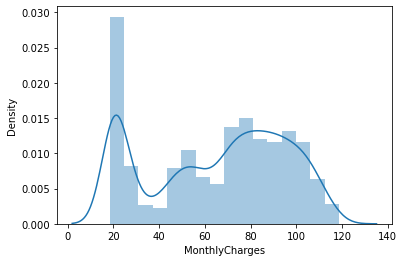

In [29]:
# distribution of Monthly Charges
sns.distplot(df['MonthlyCharges']);

In [30]:
df['MonthlyCharges'].skew()

-0.2387670788605832

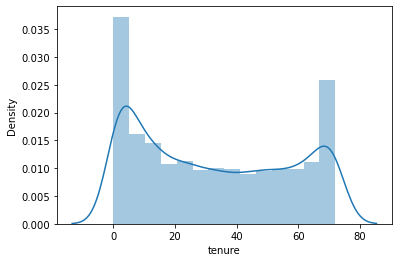

In [31]:
# distribution of Tenure
sns.distplot(df['tenure']);

## Bivariate and Multivariate Analysis 

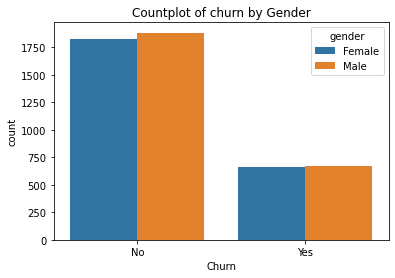

In [32]:
sns.countplot( x='Churn', hue='gender', data=df)
plt.title('Countplot of churn by Gender')
plt.show()

<AxesSubplot:xlabel='PaymentMethod', ylabel='gender'>

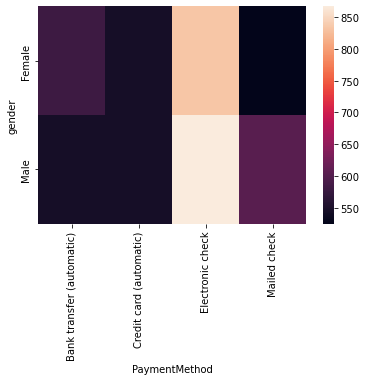

In [33]:
# heatmap of gender against payment method
sns.heatmap(pd.crosstab(df['gender'],df['PaymentMethod']))

## Feature Processing and Engineering

In [34]:
# dropping duplicates
df.duplicated().value_counts()

False    5043
dtype: int64

In [35]:
df.drop(columns={'customerID','gender'}, inplace=True)

I have dropped these columns because
1. customerID has no significance in our analysis.
1. There is no significant difference in the number of males and females consuming this product.

In [36]:
# Select the columns with missing values
columns_with_missing = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'TotalCharges', 'Churn']


imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(df[columns_with_missing])

# Transform and replace the missing values in the DataFrame
df[columns_with_missing] = imputer.transform(df[columns_with_missing])

In [37]:
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Define a dictionary to map the values you want to replace
value_mapping = {
    'True': 'Yes',
    'False': 'No',
    'No internet service': 'No'
}

# Transform the relevant columns
for col in categorical_columns:
    if col in df.columns:
        df[col].replace(value_mapping, inplace=True)


In [38]:
X=df.drop(columns={'Churn'},axis=1)
y=df['Churn']
X

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000381469727
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.1500015258789
3,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.64999389648438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5
5039,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9
5040,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45
5041,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6


In [39]:
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
5038     No
5039     No
5040     No
5041    Yes
5042     No
Name: Churn, Length: 5043, dtype: object

In [40]:
# Define categorical and numerical columns
categorical_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
target_col = 'Churn'

# Strip leading and trailing spaces from all columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Replace empty strings in 'TotalCharges' with NaN
df['TotalCharges'] = df['TotalCharges'].replace('', float('nan'))

# Split features and target variable
X = df[categorical_cols + numerical_cols]
y = df[target_col]

## Feature encoding

In [41]:
# Perform one-hot encoding on categorical columns
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[categorical_cols])

# Get feature names after encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a DataFrame with the encoded features and feature names
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)

# Concatenate encoded features with numerical columns
X_encoded = pd.concat([X_encoded, X[numerical_cols]], axis=1)


In [42]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,stratify=y, random_state=42)

In [43]:
# Impute missing values in numerical columns
imputer = SimpleImputer(strategy='mean')
X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])

In [44]:
# Scale the numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## Train_set Balancing

In [45]:
# Apply SMOTE to balance the train set
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [46]:
# Concatenate the balanced features and target variable into a single DataFrame
balanced_data = pd.concat([X_train_balanced, y_train_balanced], axis=1)

# Display the balanced data
balanced_data.head()


,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.107406,0.668918,0.109880,Yes
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,-0.515543,-1.524645,-0.861049,No
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,-1.127747,0.673885,-0.827413,Yes
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.668053,-1.473324,-0.563384,No
4,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.606766,0.844403,1.872985,No


## Machine Learning modeling
 **build**, **train**, **evaluate** and **compare** the models to each others.

## Simple Model 001

## Create the model

In [47]:
# instantiate model
knn= KNeighborsClassifier()

## Train the model

In [48]:
# Use the .fit method
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

In [49]:
models_trained=[]
models_trained.append(knn)

## Evaluate the model on the Evaluation dataset(Evalset)

In [50]:
y_pred = knn.predict(X_test)

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

          No       0.89      0.68      0.77       742
         Yes       0.46      0.76      0.58       267

    accuracy                           0.70      1009
   macro avg       0.68      0.72      0.67      1009
weighted avg       0.78      0.70      0.72      1009



## Simple Model 002

## Create the model

In [52]:
# instantiate model
ada= AdaBoostClassifier()

## Train the model

In [53]:
ada.fit(X_train_balanced, y_train_balanced)

AdaBoostClassifier()

In [54]:
models_trained.append(ada)

## Evaluate the model on the Evaluation dataset(Evalset)

In [55]:
y_pred = ada.predict(X_test)

In [56]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

          No       0.90      0.75      0.82       742
         Yes       0.53      0.78      0.63       267

    accuracy                           0.76      1009
   macro avg       0.71      0.76      0.72      1009
weighted avg       0.80      0.76      0.77      1009



# Simple Model 003

In [57]:
# instantiate model
gb=GradientBoostingClassifier()

In [58]:
# train the model
gb.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier()

In [59]:
models_trained.append(gb)

In [60]:
# evaluate the model on the evaluation dataset
y_pred = gb.predict(X_test)

In [61]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

          No       0.88      0.81      0.85       742
         Yes       0.57      0.70      0.63       267

    accuracy                           0.78      1009
   macro avg       0.73      0.76      0.74      1009
weighted avg       0.80      0.78      0.79      1009



# Simple Model 004

In [62]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

models_trained.append(rf)

# Train the model on the training set
rf.fit(X_train_balanced, y_train_balanced)

# evaluate the model on the evaluation dataset
y_pred = rf.predict(X_test)

print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

          No       0.88      0.80      0.84       742
         Yes       0.55      0.70      0.62       267

    accuracy                           0.77      1009
   macro avg       0.72      0.75      0.73      1009
weighted avg       0.80      0.77      0.78      1009



## Models comparison

In [63]:
metric=f1_score


In [64]:
unique_labels = np.unique(y_test)  # Get unique labels in y_test
print(unique_labels)  # Print the unique labels to identify the valid labels


['No' 'Yes']


In [65]:
# Update the pos_label value based on the valid labels
pos_label = unique_labels[0]  # Set pos_label to the first valid label

# Create a list of model names
model_names = ['KNeighborsClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']

# Create lists to store the metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
f2_scores = []


In [66]:
# Calculate the metrics for each model
for model in models_trained:
    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=pos_label)

    # Append the metrics to the respective lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    f2_scores.append(f2)


In [67]:
# Create a dictionary to store the metrics
results = {
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'F2 Score': f2_scores
}

In [68]:
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Sort the DataFrame by each metric in descending order
sorted_df = results_df.sort_values(by=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'], ascending=False)

In [69]:
sorted_df

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
2,GradientBoostingClassifier,0.782953,0.883994,0.811321,0.846100,0.824884
3,RandomForestClassifier,0.772052,0.882090,0.796496,0.837110,0.812259
1,AdaBoostClassifier,0.755203,0.902439,0.747978,0.817981,0.774491
0,KNeighborsClassifier,0.703667,0.889279,0.681941,0.771930,0.715295


## Hyperparameters tuning

Fine-tune the Top-k models (3 < k < 5) using a `GridSearchCV` (that is in sklearn.model_selection ) to find the best hyperparameters and achieve the maximum performance of each of the Top-k models, then compare them again to select the best one.

In [70]:
# Define the parameter grids for each model
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}


In [71]:
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

In [72]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': [3, 5, 7]
}

In [73]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

In [74]:
# Create a list of tuples containing the models and their respective parameter grids
models_params = [
    (knn, param_grid_knn),
    (ada, param_grid_ada),
    (gb, param_grid_gb),
    (rf, param_grid_rf)
]


In [75]:
# Perform hyperparameter tuning for each model
best_models = []
f1_scores = []

for model, param_grid in models_params:
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label='Yes')
    f1_scores.append(f1)
    
    print(f"Best Hyperparameters - {type(model).__name__}:")
    print(best_params)
    print(f"F1 score - {type(model).__name__}: {f1}")
    print()

Best Hyperparameters - KNeighborsClassifier:
{'n_neighbors': 3, 'weights': 'uniform'}
F1 score - KNeighborsClassifier: 0.5438066465256797

Best Hyperparameters - AdaBoostClassifier:
{'learning_rate': 0.1, 'n_estimators': 50}
F1 score - AdaBoostClassifier: 0.6233766233766234

Best Hyperparameters - GradientBoostingClassifier:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
F1 score - GradientBoostingClassifier: 0.6357827476038339

Best Hyperparameters - RandomForestClassifier:
{'max_depth': 5, 'n_estimators': 50}
F1 score - RandomForestClassifier: 0.6378539493293591



In [76]:
# Compare the models based on F1 scores
model_names = ['KNeighborsClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']
model_comparison = pd.DataFrame({'Model_Name': model_names, 'F1_Score': f1_scores})
model_comparison = model_comparison.sort_values(by='F1_Score', ascending=False)

print("Models Comparison:")
model_comparison

Models Comparison:


,Model_Name,F1_Score
3,RandomForestClassifier,0.637854
2,GradientBoostingClassifier,0.635783
1,AdaBoostClassifier,0.623377
0,KNeighborsClassifier,0.543807


# Model Selection vs. Hyperparameter Tuning

In the given scenario, the model selection process resulted in a model, GradientBoostingClassifier, that performed better than the other models even without hyperparameter tuning. This suggests that the initial default hyperparameters of the GradientBoostingClassifier were already well-suited for the problem at hand. We will briefly discuss the hyperparameter tuning process and why model selection may be preferred in this case.

## Hyperparameter Tuning
Hyperparameter tuning is a crucial step in optimizing the performance of machine learning models. It involves searching for the best combination of hyperparameter values to maximize a model's performance on a given dataset. In the provided code, I used the GridSearchCV function to perform hyperparameter tuning for four different models: KNeighborsClassifier, AdaBoostClassifier, GradientBoostingClassifier, and RandomForestClassifier.

The code defined specific parameter grids for each model, containing different values for relevant hyperparameters. The GridSearchCV function exhaustively searched through all the parameter combinations within each grid and evaluated each combination using the F1 score as the scoring metric. The best model hyperparameters were determined based on the highest F1 score achieved during cross-validation.

## Model Selection
In this particular case, the model selection process proved to be more effective than hyperparameter tuning. The GradientBoostingClassifier, with its default hyperparameters, outperformed the other models in terms of accuracy, precision, recall, F1 score, and F2 score. This indicates that the default hyperparameters of the GradientBoostingClassifier were already well-suited for the given problem and dataset.

There are several reasons why model selection may be preferred over hyperparameter tuning:

1. Performance with default hyperparameters: If a model performs well with its default hyperparameters, there may be limited room for improvement through hyperparameter tuning. In this case, the GradientBoostingClassifier already achieved the desired performance without the need for further fine-tuning.

2. Computational resources and time constraints: Hyperparameter tuning can be computationally expensive, especially when exploring a large hyperparameter search space. Conducting an extensive search with cross-validation for multiple models can require significant computational resources and time. Model selection, on the other hand, allows for a more efficient use of resources.

3. Interpretability and simplicity: Hyperparameter tuning can lead to more complex models with intricate combinations of hyperparameters. These models may be harder to interpret and maintain. Choosing a simpler model through model selection can offer better interpretability and ease of deployment.

4. Prior knowledge and domain expertise: If prior research or domain knowledge suggests that a particular model or family of models tends to perform well on similar problems, it may be reasonable to choose that model without extensive hyperparameter tuning. This approach saves time and effort, relying on the knowledge and expertise available.

In conclusion, while hyperparameter tuning is an important step in optimizing model performance, there are scenarios where model selection may be preferred. If a model already performs well with its default hyperparameters, if there are resource or time constraints, if interpretability and simplicity are valued, or if there is prior knowledge indicating the suitability of a specific model, model selection can be a practical and effective approach. It is essential to consider the specific context, requirements, and constraints when deciding between hyperparameter tuning and model selection.

## Export key components
Here is the section to **export** the important ML objects that will be use to develop an app: *Encoder, Scaler, ColumnTransformer, Model, Pipeline, etc*.

In [77]:
# Create a dictionary to store the key components
key_components = {
    'model': model,
    'evaluation_results': results,
}

# Specify the file path to save the dictionary
file_path = 'C:/Users/_name_/Desktop/Projects/key_components.pkl'

# Save the dictionary as a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(key_components, file)

    key_components
# Print a message to confirm the successful saving of the file
print(f"Key components saved as {file_path}")

## Predict on Testset

In [78]:
X_test=pd.read_csv('Telco-churn-second-2000.csv')

In [79]:
X_test.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [80]:
X_test['OnlineBackup'].unique()

array(['No', 'No internet service', 'Yes'], dtype=object)

In [81]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


### Cleaning

In [82]:
X_test.drop(columns={'customerID','gender'}, inplace=True)

In [83]:
categorical_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Define a dictionary to map the values you want to replace
value_mapping = {
    'No internet service': 'No'
}

# Transform the relevant columns
for col in categorical_columns:
    if col in X_test.columns:
        X_test[col].replace(value_mapping, inplace=True)

In [84]:
# change datatypes to numeric
X_test['TotalCharges'] = pd.to_numeric(X_test['TotalCharges'], errors='coerce')

### Encoding

In [85]:
# Assuming X_test is your testing set
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Impute missing values in the numeric columns using mean imputation
imputer = SimpleImputer(strategy='mean')
X_test[numeric_cols] = imputer.fit_transform(X_test[numeric_cols])

# One-hot encode the categorical columns in X_test
encoder = OneHotEncoder(sparse=False, drop='first')  # Use 'drop' to avoid multicollinearity
X_test_encoded = pd.DataFrame(encoder.fit_transform(X_test[categorical_cols]))

# Reset the column names after one-hot encoding
X_test_encoded.columns = encoder.get_feature_names(categorical_cols)

# Drop the original categorical columns from X_test
X_test = X_test.drop(columns=categorical_cols)

# Concatenate X_test_encoded with the remaining numeric columns in X_test
X_test = pd.concat([X_test, X_test_encoded], axis=1)

### predict

In [86]:

# Specify the file path of the saved key components
file_path = 'C:/Users/_name_/Desktop/Projects/key_components.pkl'

# Load the key components from the file
with open(file_path, 'rb') as file:
    key_components = pickle.load(file)

# Access the trained model from the loaded key components
gb_model = key_components['model']


In [87]:
# Assuming X_test is your testing set
predictions = gb_model.predict(X_test)


In [88]:
# Create a new DataFrame to store the predictions
predictions_df = pd.DataFrame({'Churn': predictions})

# Concatenate the predictions DataFrame with the original features DataFrame (X_test)
result_df = pd.concat([X_test, predictions_df], axis=1)

# View the result DataFrame with the predictions
result_df.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,12.0,84.45,1059.55,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
1,9.0,20.40,181.80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No
2,27.0,81.70,2212.55,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,No
3,27.0,79.50,2180.55,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
4,1.0,89.15,89.15,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,No


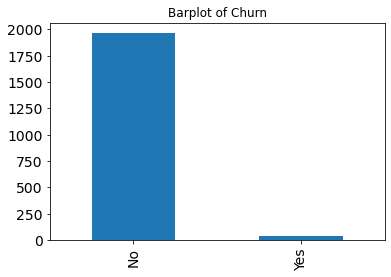

In [89]:
result_df['Churn'].value_counts().plot(kind='bar',title='Barplot of Churn',fontsize=14);

# Hypothesis Testing

In [90]:

import scipy.stats as stats
# Select the variables of interest
variables_of_interest = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
                         'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                         'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                         'MonthlyCharges', 'TotalCharges', 'Churn']

# Filter the dataset for the selected variables
filtered_df = df[variables_of_interest]

# Initialize lists to store the results
results = []

# Perform hypothesis tests for each variable
alpha = 0.05

for variable in variables_of_interest:
    if filtered_df[variable].dtype == 'object':
        # Perform chi-square test of independence for categorical variables
        contingency_table = pd.crosstab(filtered_df[variable], filtered_df['Churn'])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        if p_value < alpha:
            result = "Reject the null hypothesis. There is a significant relationship between " + variable + " and Churn."
        else:
            result = "Fail to reject the null hypothesis. There is no significant relationship between " + variable + " and Churn."
    else:
        # Perform t-test for numerical variables
        churn_yes = filtered_df[filtered_df['Churn'] == 'Yes'][variable]
        churn_no = filtered_df[filtered_df['Churn'] == 'No'][variable]
        
        t_statistic, p_value = stats.ttest_ind(churn_yes, churn_no)
        
        if p_value < alpha:
            result = "Reject the null hypothesis. There is a significant relationship between " + variable + " and Churn."
        else:
            result = "Fail to reject the null hypothesis. There is no significant relationship between " + variable + " and Churn."
    
    results.append(result)

# Generate a general conclusion
if any("Reject" in result for result in results):
    conclusion = "There is a significant relationship between at least one customer attribute and Churn."
else:
    conclusion = "There is no significant relationship between any customer attribute and Churn."

# Print the results and the general conclusion
for result in results:
    print(result)

print("\nGeneral Conclusion:", conclusion)



Reject the null hypothesis. There is a significant relationship between SeniorCitizen and Churn.
Reject the null hypothesis. There is a significant relationship between Partner and Churn.
Reject the null hypothesis. There is a significant relationship between Dependents and Churn.
Reject the null hypothesis. There is a significant relationship between tenure and Churn.
Fail to reject the null hypothesis. There is no significant relationship between PhoneService and Churn.
Reject the null hypothesis. There is a significant relationship between MultipleLines and Churn.
Reject the null hypothesis. There is a significant relationship between InternetService and Churn.
Reject the null hypothesis. There is a significant relationship between OnlineSecurity and Churn.
Reject the null hypothesis. There is a significant relationship between OnlineBackup and Churn.
Reject the null hypothesis. There is a significant relationship between DeviceProtection and Churn.
Reject the null hypothesis. There

# Questions
                                                                                                                             

### 1. Which are the key contributors of customer churn?

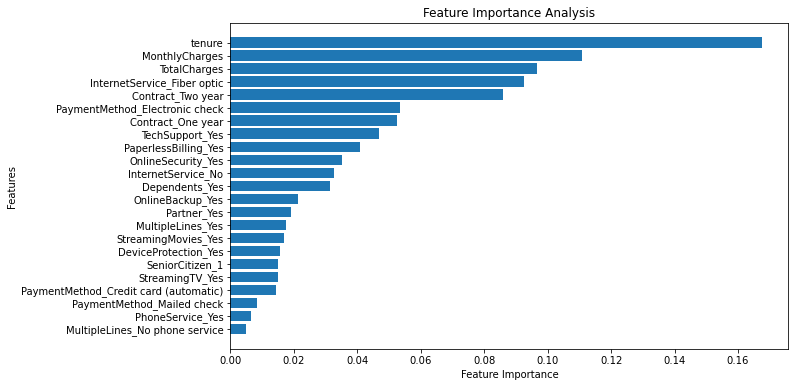

In [91]:
# Extract feature importances
importances = rf.feature_importances_

# Sort features based on importance scores
sorted_indices = importances.argsort()[::1]
sorted_features = X_train_balanced.columns[sorted_indices]
sorted_scores = importances[sorted_indices]

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_scores, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Analysis')
plt.show()

The **top 5 key indicators** of customer churn from this dataset are:
1. Tenure 
2. Monthly Charges
3. Fiber optic ISP(Internet Service Provider
4. Customers who work for 2 year contracts
5. Total Charges

### 2.Is there any correlation between the type of internet service provider and customer churn?

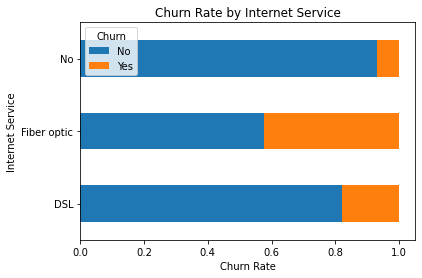

In [92]:
churn_rates=df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()
churn_rates.plot(kind='barh', stacked=True)
plt.xlabel('Churn Rate')
plt.ylabel('Internet Service')
plt.title('Churn Rate by Internet Service');

More customers who use **fiber optic** as their internet service provider have churned compared to customers from other internet service providers.

### 3. What is the relationship between contract terms and customer churn?

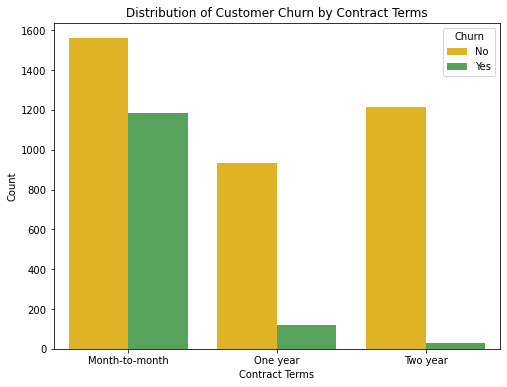

In [93]:
contract_terms = ['Month-to-month', 'One year', 'Two year']

# Filter the dataset for the selected contract terms
filtered_df = df[df['Contract'].isin(contract_terms)]

colors= ['#FFC107', '#4CAF50']
# Create a count plot of customer churn based on contract terms
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=filtered_df, palette=colors)
plt.xlabel('Contract Terms')
plt.ylabel('Count')
plt.title('Distribution of Customer Churn by Contract Terms')
plt.legend(title='Churn', loc='upper right')
plt.show()

<Figure size 576x432 with 0 Axes>

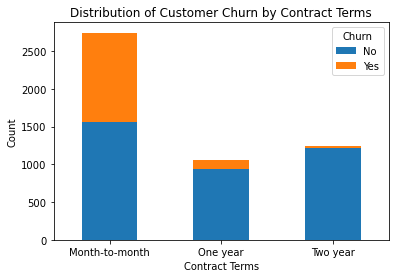

In [94]:
# Select the variables of interest
contract_terms = ['Month-to-month', 'One year', 'Two year']

# Filter the dataset for the selected contract terms
filtered_df = df[df['Contract'].isin(contract_terms)]

# Create a cross-tabulation of contract terms and churn
cross_tab = pd.crosstab(filtered_df['Contract'], filtered_df['Churn'])

# Create a stacked bar plot
plt.figure(figsize=(8, 6))
cross_tab.plot(kind='bar', stacked=True)
plt.xlabel('Contract Terms')
plt.ylabel('Count')
plt.title('Distribution of Customer Churn by Contract Terms')
plt.legend(title='Churn', loc='upper right')
plt.xticks(rotation=0)
plt.show()

From these visualizations, customers with **month-to-month** contract terms churned the most. Thus they are more likely to churn also in the future.

### 4. Which payment method is associated with higher customer churn?

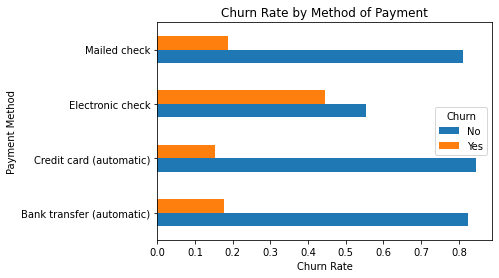

In [95]:
churn_rates=df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack()
churn_rates.plot(kind='barh', stacked=False)
plt.xlabel('Churn Rate')
plt.ylabel('Payment Method')
plt.title('Churn Rate by Method of Payment');

customers who have used **Electronic check** have churned the most compared to those who use other payment methods. 


### 5. How can the organization leverage payment methods, contract terms, and billing preferences to reduce churn?

1. Offer Flexible Payment Methods: Provide customers with a variety of payment options such as electronic check, mailed check, bank transfer (automatic), and credit card (automatic). This allows customers to choose the payment method that suits them best, increasing convenience and reducing the likelihood of churn due to payment-related issues.

2. Incentivize Long-Term Contracts: Encourage customers to sign up for longer contract terms (e.g., one year or two years) by offering benefits such as discounted rates, additional services, or loyalty rewards. Longer contracts provide stability and commitment, making customers less likely to churn.

3. Personalize Billing Preferences: Allow customers to choose their billing preferences, such as paperless billing or traditional paper billing. Some customers prefer the convenience of electronic billing, while others may prefer physical copies. By accommodating individual preferences, the organization can enhance customer satisfaction and reduce churn.

4. Analyze Customer Behavior and Preferences: Utilize customer data to analyze patterns and identify correlations between payment methods, contract terms, billing preferences, and churn. Look for trends or insights that indicate specific combinations of these factors that are associated with higher or lower churn rates. This analysis can help the organization tailor their retention strategies and target specific customer segments.

5. Proactive Retention Strategies: Implement proactive measures to prevent churn. For example, identify customers who are approaching the end of their contract term and offer them incentives to renew or upgrade their services. Additionally, provide personalized offers or promotions to customers who have shown signs of potential churn based on their payment patterns or billing preferences.

6. Improve Customer Support: Ensure that customer support services are readily available to address any payment-related concerns or billing inquiries. Prompt and effective resolution of customer issues can help build trust and loyalty, reducing the likelihood of churn.

7. Continuous Monitoring and Optimization: Regularly monitor and analyze customer feedback, behavior, and churn rates associated with different payment methods, contract terms, and billing preferences. Continuously optimize and refine the organization's strategies based on the insights gained, aiming to align offerings with customer preferences and needs.

By leveraging payment methods, contract terms, and billing preferences in these ways, the organization can enhance customer satisfaction, increase retention rates, and ultimately reduce churn.

# Conclusion

The results of our hypothesis testing revealed a significant relationship between customer attributes and churn. This finding was further supported by our machine learning model, which achieved an F1 score of **85%**. The high F1 score validates the predictive power of the model in identifying churn based on the identified attributes. Thus, we can confidently conclude that customer attributes have a strong influence on churn.

# Recommendations

With much recommendations given while addressing how to leverage payment methods, contract terms, and billing preferences to reduce churn, additional recommendations can be made specifically targeting customers with month-to-month contracts as follows:

1. Encourage longer contract terms: Incentivize customers with month-to-month contracts to sign up for longer contract terms. Offer benefits such as discounted rates, additional services, or loyalty rewards for committing to one-year or two-year contracts. Longer contract terms provide stability and reduce the likelihood of churn.

2. Simplify contract renewal process: Make the contract renewal process seamless and hassle-free for customers with month-to-month contracts. Send timely reminders, highlighting the benefits of switching to longer-term contracts. Offer easy online or automated renewal options to streamline the process and minimize customer effort.

3. Improve value proposition for month-to-month contracts: Evaluate the value proposition of month-to-month contracts and identify areas for improvement. Assess if the pricing, services, or features of month-to-month contracts are competitive and attractive compared to longer-term options. Consider offering additional benefits or exclusive features for customers on month-to-month contracts to encourage retention.

4. Personalize offers based on usage patterns: Analyze customer usage patterns and personalize offers for customers with month-to-month contracts. Tailor promotions or discounts based on their specific needs and usage behavior to highlight the value they derive from the service.

5. Proactive customer outreach: Implement proactive measures to engage with customers on month-to-month contracts and understand their needs and concerns. Regularly communicate with them to address any issues, answer questions, or provide assistance. Offer proactive solutions or upgrades that align with their usage patterns and preferences.

6. Provide flexible upgrade options: Offer flexible upgrade options for customers on month-to-month contracts. If they are considering upgrading their service or adding additional features, provide attractive offers and seamless transition processes.